### Compute MOCfor the CMEMS Reanalysis

https://resources.marine.copernicus.eu/product-detail/GLOBAL_REANALYSIS_PHY_001_031/INFORMATION

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
from xhistogram.xarray import histogram
from geopy.distance import great_circle
import matplotlib.pyplot as plt
from metpy.calc import lat_lon_grid_deltas
import distributed
import ncar_jobqueue
from mom6_tools.m6toolbox import genBasinMasks 
from mom6_tools.m6plot import xyplot
from mom6_tools import m6plot
import warnings, getpass, os

%matplotlib inline

Basemap module not found. Some regional plots may not function properly


In [2]:
cluster = ncar_jobqueue.NCARCluster()

cluster.scale(20)

client = distributed.Client(cluster)
client

/glade/u/apps/opt/conda/envs/npl-2022b/lib/python3.8/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41679 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/41679/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/41679/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.60:39600,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/41679/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
#cluster.close()
#client.close()

In [4]:
def weighted_temporal_mean(ds, var):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds[var]

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

### 1. Read in OGCM history files

In [5]:
path = '/glade/scratch/gmarques/glorys2v4/'
ds_mon = []
ds = []
models = ['glor','foam','cglo','oras']
for m in models:
    fname = '{}_*_??.nc'.format(m)
    ds1 = xr.open_mfdataset(path+fname, parallel=True)
    vname = 'vo_{}'.format(m)
    ds.append(ds1[vname])
    #ds2 = weighted_temporal_mean(ds1, vname)
    #ds.append(ds2)

### 2. Build grid

In [6]:
# calculate dx and dy, this is an approximation - this function is very fast compared to other ways of 
# calculating dx
dx_tmp, dy_tmp = lat_lon_grid_deltas(ds[0].longitude, ds[0].latitude)
# convert from pint.util.Quantity to numpy ndarray
dx_tmp = np.array(dx_tmp) # in m
dy_tmp = np.array(dy_tmp) # in m

In [7]:
dx = np.zeros(ds[0][0,0,:].shape)
dy = np.zeros(ds[0][0,0,:].shape)
# dx
# the grid is already on the corner points, we will approximate dx in the last 
# column im using values from column im-1
dx[:,0:-1] = dx_tmp[:,:]
dx[:,-1] = dx_tmp[:,-1]
# same for dy
dy[0:-1,:] = dy_tmp[:,:]
dy[-1,:] = dy_tmp[-1,:]
area = dx * dy    # in m^2

In [8]:
depth_tmp = ds[0].depth.data
depth = np.zeros(len(depth_tmp)+1)
interface = np.zeros(len(depth_tmp)+1)
depth[1:-1] = 0.5 * (depth_tmp[0:-1] + depth_tmp[1::])
depth[-1] = 6000.
dz = depth[1::] - depth[0:-1]

In [9]:
for k in range(len(dz)):
    interface[k+1] = interface[k] + dz[k]

In [10]:
interface

array([0.00000000e+00, 1.03080750e+00, 2.11176848e+00, 3.26198101e+00,
       4.49832058e+00, 5.84169769e+00, 7.31777668e+00, 8.95763397e+00,
       1.07982149e+01, 1.28823605e+01, 1.52581806e+01, 1.79775600e+01,
       2.10937099e+01, 2.46579590e+01, 2.87164307e+01, 3.33073807e+01,
       3.84601097e+01, 4.41959534e+01, 5.05312653e+01, 5.74817390e+01,
       6.50672607e+01, 7.33164215e+01, 8.22702942e+01, 9.19853668e+01,
       1.02535805e+02, 1.14015152e+02, 1.26537903e+02, 1.40240997e+02,
       1.55285355e+02, 1.71857208e+02, 1.90169952e+02, 2.10465607e+02,
       2.33015900e+02, 2.58123505e+02, 2.86121948e+02, 3.17375153e+02,
       3.52275635e+02, 3.91241211e+02, 4.34709778e+02, 4.83132751e+02,
       5.36966064e+02, 5.96659180e+02, 6.62642334e+02, 7.35313477e+02,
       8.15023682e+02, 9.02063477e+02, 9.96650940e+02, 1.09892249e+03,
       1.20892603e+03, 1.32661890e+03, 1.45187048e+03, 1.58446606e+03,
       1.72411951e+03, 1.87048352e+03, 2.02316162e+03, 2.18172461e+03,
      

In [11]:
# create dataset with grid info
grd = xr.Dataset(
    data_vars=dict(
        dx=(["latitude", "longitude"], dx),
        dy=(["latitude", "longitude"], dy),
        area=(["latitude", "longitude"], area),
        dz=(["depth"], dz),
    ),
    coords=dict(
        longitude=(["longitude"], ds[0].longitude.data),
        latitude=(["latitude"], ds[0].latitude.data),
    ),
    attrs=dict(description="Grid info (approximate)"),
)
grd

<xarray.Dataset>
Dimensions:    (latitude: 681, longitude: 1440, depth: 75)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 -80.0 -79.75 -79.5 -79.25 ... 89.5 89.75 90.0
Dimensions without coordinates: depth
Data variables:
    dx         (latitude, longitude) float64 4.827e+03 4.827e+03 ... 0.0 0.0
    dy         (latitude, longitude) float64 2.78e+04 2.78e+04 ... 2.78e+04
    area       (latitude, longitude) float64 1.342e+08 1.342e+08 ... 0.0 0.0
    dz         (depth) float64 1.031 1.081 1.15 1.236 ... 203.2 203.7 199.9
Attributes:
    description:  Grid info (approximate)

### Generate basin masks

In [12]:
# basin masks 
tmp = ds[0][0,0,:].values
topo = np.ones(tmp.shape) * 10.
# remove Nan's, otherwise genBasinMasks won't work
topo[np.isnan(tmp)] = 0.0
geolon, geolat = np.meshgrid(ds[0].longitude, ds[0].latitude)
basin_code = genBasinMasks(geolon, geolat, topo, verbose=True, xda=True)

Generating global wet mask...
done.
Finding Cape of Good Hope ...
done. -34.75
Finding Melbourne ...
done. 0.0
Processing Persian Gulf ...
Processing Red Sea ...
Processing Black Sea ...
Processing Mediterranean ...
Processing Baltic ...
Processing Hudson Bay ...
Processing Arctic ...
Processing Pacific ...
Processing Atlantic ...
Processing Indian ...
Processing Southern Ocean ...
There are leftover points unassigned to a basin code
-53.25 68.0 [592, 507]
-53.0 68.0 [592, 508]
Processing Labrador Sea ...
Processing Baffin Bay ...

  Basin codes:
  -----------------------------------------------------------
  (0) Global              (7) Black Sea
  (1) Southern Ocean      (8) Hudson Bay
  (2) Atlantic Ocean      (9) Baltic Sea
  (3) Pacific Ocean       (10) Red Sea
  (4) Arctic Ocean        (11) Persian Gulf
  (5) Indian Ocean        (12) Lab Sea
  (6) Mediterranean Sea   (13) Baffin Bay

  Important: basin codes overlap. Code 12 and 13 are only loaded if xda=True.

    


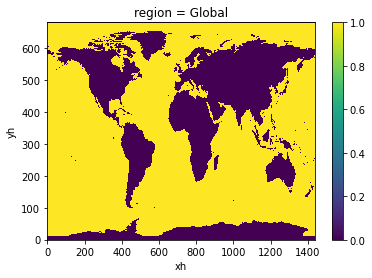

In [13]:
basin_code[0,:].plot()

In [14]:
## uncomment this to see all region masks
#vals = np.unique(basin_code)
#for v in vals:
#    dummy = np.zeros(basin_code.shape)
#    dummy[basin_code == v] = v
#    dummy = np.ma.masked_where(topo == 0., dummy)
#    plt.figure(figsize=(12,8))
#    xyplot(dummy, geolon, geolat,title='Code = '+str(v))

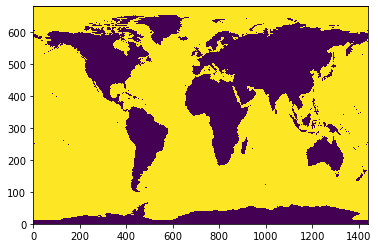

In [15]:
plt.pcolormesh(topo)

In [16]:
basin_code = basin_code.rename({'xh':'longitude', 'yh':'latitude'})

In [17]:
basin_code.region

<xarray.DataArray 'region' (region: 14)>
array(['Global', 'PersianGulf', 'RedSea', 'BlackSea', 'MedSea', 'BalticSea',
       'HudsonBay', 'Arctic', 'PacificOcean', 'AtlanticOcean', 'IndianOcean',
       'SouthernOcean', 'LabSea', 'BaffinBay'], dtype='<U13')
Coordinates:
  * region   (region) <U13 'Global' 'PersianGulf' ... 'LabSea' 'BaffinBay'

In [18]:
#m = 0*basin_code; m[(basin_code==2) | (basin_code==4) | (basin_code==6) | (basin_code==7) | (basin_code==8)]=1
atl_mask = (basin_code.sel(region='HudsonBay') + basin_code.sel(region='Arctic') + \
            basin_code.sel(region='BlackSea') + basin_code.sel(region='MedSea') + \
            basin_code.sel(region='AtlanticOcean')).rename('atl_mask')

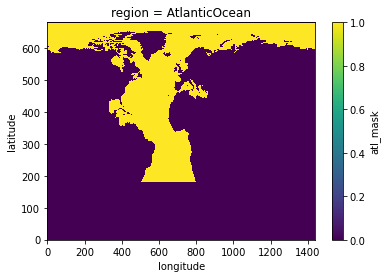

In [19]:
atl_mask.plot()

### 3. Volume fluxes and MOC

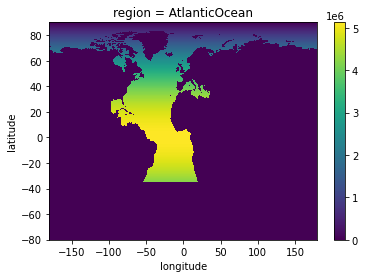

In [20]:
dxdz = grd['dz']*grd['dx']
(dxdz[60,:]*atl_mask).plot()

In [21]:
# add mean vo
vo_mean = 0.25 * (ds[0] +  ds[1] +  ds[2] +  ds[3])
vo_mean

,Array,Chunk
Bytes,86.03 GiB,280.56 MiB
Shape,"(314, 75, 681, 1440)","(1, 75, 681, 1440)"
Count,7139 Tasks,314 Chunks
Type,float32,numpy.ndarray


In [28]:
vo_mean.coords['time'][3]

<xarray.DataArray 'time' ()>
array('1994-01-16T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1994-01-16
Attributes:
    axis:                 T
    long_name:            Time
    standard_name:        time
    cell_methods:         time: mean
    _ChunkSizes:          1024
    _CoordinateAxisType:  Time
    valid_min:            15750.5
    valid_max:            15750.5

In [22]:
# grid-oriented volume fluxes in Sv
vflux = []
for i in range(len(models)):
    vo = ds[i]
    vflux.append(vo*dxdz/1.e6)
vflux.append(vo_mean*dxdz/1.e6)

In [23]:
# plotting function
def plot_moc(psi, y, z, title, cmax=40.):
    m6plot.setFigureSize([16,9],576)
    axis = plt.gca()
    cmap = plt.get_cmap('dunnePM')
    y = ds[0].latitude.values
    ci=m6plot.pmCI(0.,cmax,5.)
    cmap = plt.get_cmap('dunnePM')
    plt.contourf(y,z,psi, levels=ci, cmap=cmap, extend='both')
    cbar = plt.colorbar()
    plt.contour(y,z,psi, levels=ci, colors='k', linewidths=0.3)
    plt.title(title)
    cbar.set_label('[Sv]'); plt.ylabel('Elevation [m]')
    plt.gca().invert_yaxis()
    return

### MOC

In [24]:
%%time
moc = []
models = ['glor','foam','cglo','oras', 'all_models']
path = '/glade/scratch/mauricio/Data/AMOC/glorys2v2/'.format(getpass.getuser())
for m, i in zip(models, range(len(models))):
    zonalsum = (vflux[i]).sum(dim={'longitude'})
    vertcsum = zonalsum.cumsum(dim='depth') - zonalsum.sum(dim='depth')
    # the result of the integration over layers is evaluated at the interfaces
    # with psi = 0 as the bottom boundary condition for the integration
    bottom_condition = xr.zeros_like(vertcsum.isel({'depth': -1}))
    moc.append(xr.concat([vertcsum, bottom_condition], dim='depth'))
    #moc[i]['depth'][:] = interface
    moc[i]['depth'] = interface
    fname = '{}_moc.nc'.format(m)
    moc[i].rename('moc').to_netcdf(path+fname)

CPU times: user 36.2 s, sys: 3.15 s, total: 39.4 s
Wall time: 3min 58s


In [ ]:
z = interface
y = ds[0].latitude.values

for i, m in zip(range(len(moc)), models):
    title = 'Global MOC, {}'.format(m)
    plot_moc(moc[i].isel(time=0).compute(), y, z, title, cmax=50.)

### AMOC

In [ ]:
%%time
amoc = []
for m, i in zip(models, range(len(models))):
    zonalsum = (vflux[i]*atl_mask).sum(dim={'longitude'})
    vertcsum = zonalsum.cumsum(dim='depth') - zonalsum.sum(dim='depth')
    # the result of the integration over layers is evaluated at the interfaces
    # with psi = 0 as the bottom boundary condition for the integration
    bottom_condition = xr.zeros_like(vertcsum.isel({'depth': -1}))
    amoc.append(xr.concat([vertcsum, bottom_condition], dim='depth'))
    fname = '{}_amoc.nc'.format(m)
    amoc[i].rename('amoc').to_netcdf(path+fname)

In [ ]:
for i, m in zip(range(len(amoc)), models):
    title = 'Atlantic MOC, {}'.format(m)
    plot_moc(amoc[i].isel(time=-1).compute(), y, z, title, cmax=30.)

### Monthly time series of maximum transport at -34.5

In [ ]:
fig, ax = plt.subplots()
for i, m in zip(range(len(amoc)), models):
    amoc[i].sel(latitude=-34.5, method='nearest').max(dim='depth').plot(ax=ax, label=m)
ax.legend()

### AMOC depth profile

In [ ]:
fig, ax = plt.subplots()
for i, m in zip(range(len(amoc)), models):
    dummy = amoc[i].sel(latitude=-34.5, method='nearest').sel(time=slice("2013-01-01","2018-01-01")).mean('time')
    dummy.plot(ax=ax,y='depth', yincrease=False, label=m)
ax.legend()